In [4]:
import calc_footprint_FFP_climatology as myfootprint_s
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import shapefile
import rasterio
import cv2
from affine import Affine
from osgeo import gdal
import pygeodesy
import pyproj as proj
import cartopy.crs as ccrs
import traceback
import os

In [7]:
os.listdir()
os.getcwd()

'/Users/miksch/git/triangle-method/tri_method_jupyter'

In [3]:
test_img = 'p37r32_20170629_vernaleddysite_reflsurf_l8.tif'
test_raster = rasterio.open(test_img)
dst_crs = test_raster.crs
test_raster.close()

RasterioIOError: p37r32_20170629_vernaleddysite_reflsurf_l8.tif: No such file or directory

In [ ]:
def bearing(endx,endy):
    '''
    Calculate bearing between the origin (0,0) and point (endx,endy)
    '''
    rad = -np.arctan2(endy-0,endx-0) + np.pi*0.5
    return (np.degrees(rad) + 360) % 360

In [ ]:
def date_parse(yr,doy,hr):
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')
    
def date_parse_sigv(doy,hr):
    yr='2018'
    return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')

flux_df = pd.read_csv('V192.txt',delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1,2]},date_parser=date_parse,index_col=0)
sigv_df = pd.read_csv('LW192.txt',delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]},date_parser=date_parse_sigv,index_col=0,names=['DOY','hrmin','mag_v','sig_v'])

test_df = pd.concat([flux_df,sigv_df],axis=1)
print(test_df)

In [ ]:
zm_s = 2.78
z0_s = 0.05
h_s = 2000.
test_df['ol'] = zm_s/test_df['z/L']
dx = 3.
orig_d = 600.
start_hr = 12
end_hr = 12

for indx, hr in enumerate(np.arange(start_hr,end_hr+1)):

    print(f'Hour: {hr}')
    
    temp_line = test_df.loc[test_df.index.hour == hr]

    try:
        temp_ffp = myfootprint_s.FFP_climatology(domain=[-orig_d,orig_d,-orig_d,orig_d],dx=dx,dy=dx,
                                zm=zm_s,z0=z0_s,h=h_s,rs=.9,
                                ol=temp_line.iloc[0].at['ol'],sigmav=temp_line.iloc[0].at['sig_v'],
                                ustar=temp_line.iloc[0].at['ustar'],wind_dir=temp_line.iloc[0].at['Dir'],
                                crop=0,fig=0,verbosity=2)
    except Exception as e:
        if indx == 0:
            new_dat = rasterio.open('test_footprint.tif','w',driver='GTiff',dtype=rasterio.float64,
                                   count=len(np.arange(start_hr,end_hr+1)),height=f_2d.shape[0],width=f_2d.shape[1],
                                    affine=aff_trans,crs='+proj=latlong',nodata=0.00000000e+000)
    
        print(f'Hour {hr} footprint failed, band {indx+1} not written.')
        print(e)
        continue
    
    f_2d = np.array(temp_ffp['fclim_2d'])
    x_2d = np.array(temp_ffp['x_2d'])
    y_2d = np.array(temp_ffp['y_2d'])
    f_2d = f_2d*dx**2
    
    t_f2d = f_2d.flatten()
    df_f2d = pd.DataFrame({'f2d':t_f2d}).sort_values(by='f2d').iloc[::-1]
    fullsum = df_f2d['f2d'].sum()
    df_f2d['cumsum_f2d'] = df_f2d['f2d'].cumsum()
    gb_df_f2d = df_f2d.groupby('f2d',as_index=True).mean()
    diff = abs(gb_df_f2d['cumsum_f2d']-0.9)
    cutoff = diff.idxmin()
    
    f_2d = np.where(f_2d>=cutoff,f_2d,np.nan)
    f_2d = np.nan_to_num(f_2d)
    
    bear = bearing(x_2d,y_2d)
    plt.pcolormesh(bear)
    plt.colorbar()
    plt.show()

    dist = np.hypot(x_2d,y_2d)
    lon = np.zeros(f_2d.shape)
    lat = np.zeros(f_2d.shape)
    
    station = pygeodesy.ellipsoidalVincenty.LatLon(40.45829,-109.5626)
    
    for i in np.arange(0,f_2d.shape[0]):
        for j in np.arange(0,f_2d.shape[1]):
            (lat[i,j],lon[i,j]) = station.destination(dist[i,j],bear[i,j]).latlon
    
    plt.pcolormesh(lon,lat,f_2d)
    plt.show()
    
    '''fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    im1 = ax1.imshow(lat,origin='lower')
    fig.colorbar(im1,ax=ax1)
    im2 = ax2.imshow(lon,origin='lower')
    fig.colorbar(im2,ax=ax2)
    plt.show()'''

    shape = f_2d.shape
    
    ys = [0,0,shape[0]-1]
    xs = [0,shape[0]-1,shape[1]-1]

    new = np.float32([[lon[i,j],lat[i,j]] for i,j in zip(ys,xs)])
    old = np.float32([[i,j] for i,j in zip(ys,xs)])
    #new = np.float32([[lon[shape[0]-1-i,j],lat[shape[0]-1-i,j]] for i,j in zip(ys,xs)])
    #old = np.float32([[i,j] for i,j in zip(ys,xs)])
    
    print(new)
    print(old)
    
    aff_trans = Affine(*cv2.getAffineTransform(old,new).flatten())
    print((0,0) * aff_trans)
    #f_2d.dtype
    print(cv2.getAffineTransform(old,new).flatten())
    

    
    new_dat.write(f_2d,indx+1)
    tag_dict = {'hour':f'{hr*100:04}','wind_dir':temp_line.iloc[0].at['Dir'],'total_footprint':gb_df_f2d['cumsum_f2d'].loc[cutoff]}
    new_dat.update_tags(indx+1,**tag_dict)


new_dat.close()

In [6]:
out_file = 'albers_doy_footprint.tif'

from rasterio.warp import calculate_default_transform, reproject, Resampling

with rasterio.open('test_footprint.tif','r+') as src:
    transform,width,height = calculate_default_transform(src.crs,dst_crs,src.width,src.height,*src.bounds,resolution=3.)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    
    with rasterio.open(out_file,'w',**kwargs) as dst:
        for i in range(1, src.count+1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.affine,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs)#,
                #resampling=Resampling.nearest)
            try:
                dst.update_tags(i,**src.tags(i))
            except:
                continue

CPLE_AppDefined: Cannot invert geotransform

{'hour': '0700', 'total_footprint': '0.900006383949', 'wind_dir': '330.1'}


/Users/miksch/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-109.56967163085938, right=-109.56967163085938
  'left=%s, right=%s') % (left, right))
/Users/miksch/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=40.452884674072266, top=40.452884674072266
  'bottom=%s, top=%s') % (bottom, top))


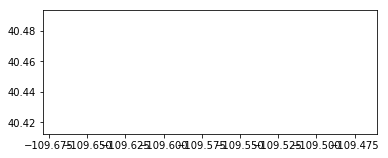

{}


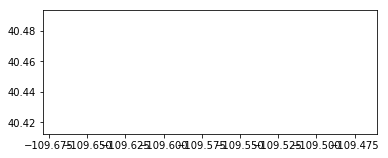

{}


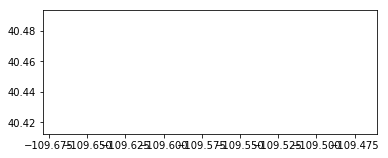

{}


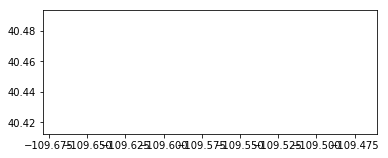

{}


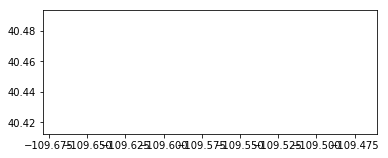

{}


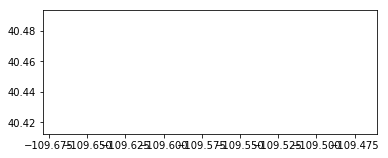

{}


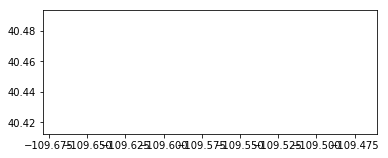

{}


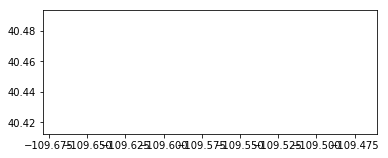

{}


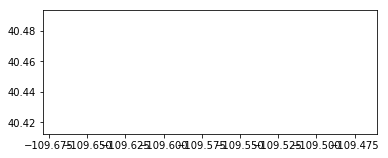

{}


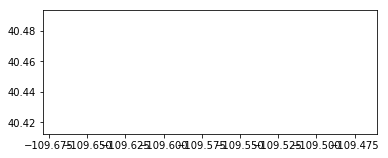

{}


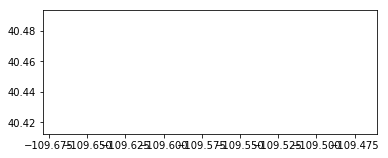

{}


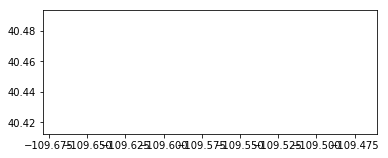

{}


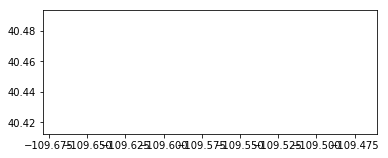

{}


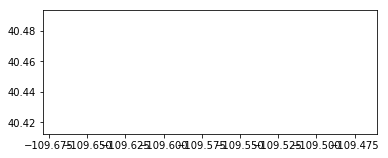

In [122]:
from rasterio.plot import show
ds = rasterio.open('test_footprint.tif')
count = ds.count
for i in np.arange(1,ds.count+1):
    print(ds.tags(i))
    show((ds,int(i)),cmap='pink')
plt.show()